## Import necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Initialize values

In [2]:
batch_size=32
image_size=252
Epochs=30
channel=3

## Load dataset 

In [8]:
data_set=tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",
batch_size=batch_size,
image_size=(image_size,image_size))

Found 2152 files belonging to 3 classes.


## Check classnames

In [9]:
class_names=data_set.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(data_set)

68

In [11]:
for image_batch,label_batch in data_set.take(2):
    print(image_batch.shape)
    print("label_batch",label_batch.numpy())

(32, 252, 252, 3)
label_batch [1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0]
(32, 252, 252, 3)
label_batch [0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 2 0 1 1 1 0 1 0 2 0 0 0 0 1 1]


## Printing the images

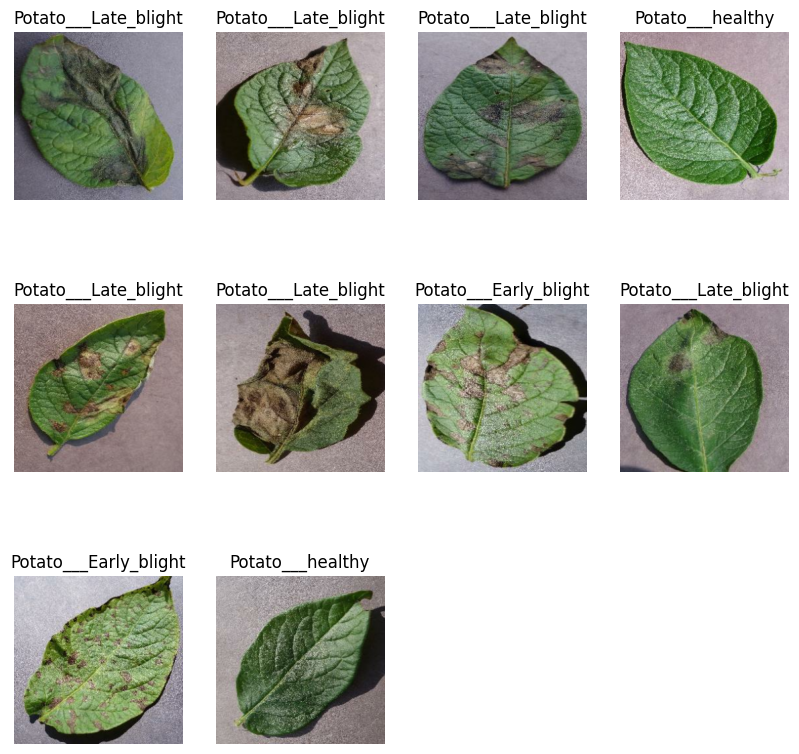

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in data_set.take(1):
    # print(image_batch.shape)
    for i in range(10):
        plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("int32"))
        plt.axis("off")

## Find size and split train, validation and test 

In [13]:
train_size=0.8
len(data_set)*train_size

54.400000000000006

In [14]:
train_dataset=data_set.take(54)


In [15]:
test_dataset=data_set.skip(54)


In [16]:
val_size=0.1
len(data_set)*val_size

6.800000000000001

In [17]:
val_data_test=test_dataset.take(6)
test_data_test=test_dataset.skip(6)

## Write a definition function for partitioning the data to test, train and validataion

In [18]:
def get_data_set_partitioning_tf(data_set,train_split=0.8,val_split=0.1,test_spli=0.1,shuffle=True,shuffle_size=10000):
    data_set_size=len(data_set)
    if shuffle:
        data_set=data_set.shuffle(shuffle_size,seed=12)
    
    train_size=int(len(data_set)*train_split)
    val_size=int(len(data_set)*val_split)

    train_dataset=data_set.take(train_size)
    val_data_set=data_set.skip(train_size).take(val_size)
    test_data_set=data_set.skip(train_size).skip(val_size)

    return train_dataset,val_data_set,test_data_set


In [19]:
train_dataset,val_data_set,test_data_set=get_data_set_partitioning_tf(data_set)

In [20]:
len(val_data_set)

6

In [21]:
len(train_dataset)

54

In [22]:
train_dataset=train_dataset.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_data_set.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_data_set.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Resize and reshape the images

In [23]:
resize_and_reshape=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

## Data augmentation

In [24]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    # layers.experimental.preprocessing.RandomRotation(0.2)
])

In [26]:
input_shape=(batch_size,image_size,image_size,channel)

model=models.Sequential([
    resize_and_reshape,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax")
    
    ])
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 252, 252, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 252, 252, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 250, 250, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 125, 125, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 123, 123, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 61, 61, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
    
)

In [29]:
history=model.fit(train_dataset,epochs=Epochs,batch_size=batch_size,verbose=1,validation_data=val_data_set)

Epoch 1/30


54/54 [==============================] - 91s 2s/step - loss: 0.8898 - accuracy: 0.4896 - val_loss: 0.8242 - val_accuracy: 0.6927
Epoch 2/30
54/54 [==============================] - 84s 2s/step - loss: 0.7421 - accuracy: 0.6319 - val_loss: 0.5852 - val_accuracy: 0.6927
Epoch 3/30
54/54 [==============================] - 87s 2s/step - loss: 0.5129 - accuracy: 0.7616 - val_loss: 0.4929 - val_accuracy: 0.7738
Epoch 4/30
54/54 [==============================] - 86s 2s/step - loss: 0.3382 - accuracy: 0.8652 - val_loss: 0.3300 - val_accuracy: 0.8542
Epoch 5/30
54/54 [==============================] - 86s 2s/step - loss: 0.3148 - accuracy: 0.8796 - val_loss: 0.2001 - val_accuracy: 0.9323
Epoch 6/30
54/54 [==============================] - 83s 2s/step - loss: 0.2770 - accuracy: 0.8854 - val_loss: 0.3890 - val_accuracy: 0.8698
Epoch 7/30
54/54 [==============================] - 85s 2s/step - loss: 0.2130 - accuracy: 0.9253 - val_loss: 0.2144 - val_accuracy: 0.9375
Epoch 8/30
54/54 [=============

In [30]:
score=model.evaluate(test_data_set)

8/8 [==============================] - 4s 272ms/step - loss: 0.0531 - accuracy: 0.9844


In [25]:
score

[0.08342695981264114, 0.98046875]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history.history["loss"][:5]

[0.9094155430793762,
 0.6919053196907043,
 0.517152726650238,
 0.404034286737442,
 0.3161093294620514]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

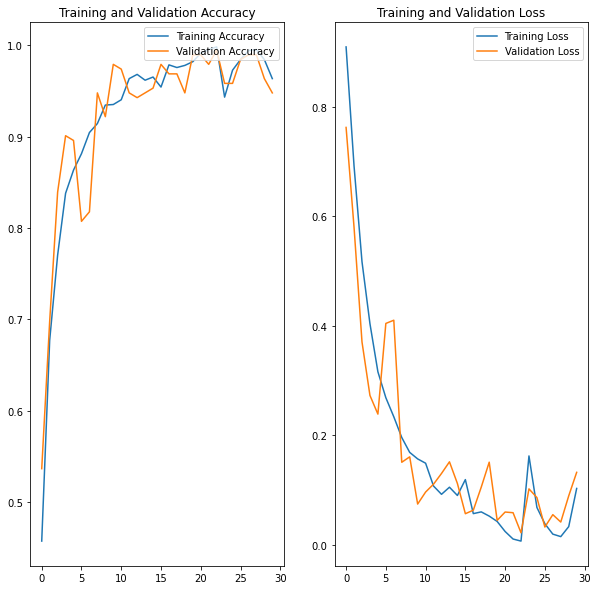

In [31]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(Epochs), loss, label='Training Loss')
plt.plot(range(Epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 314ms/step
Potato___Early_blight


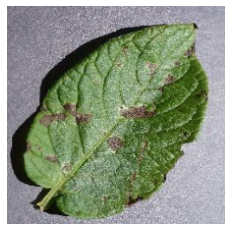

In [32]:
import numpy as np
for image_batch,label_batch in test_data_set.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])
    # print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 291ms/step
predicted label: Potato___Early_blight


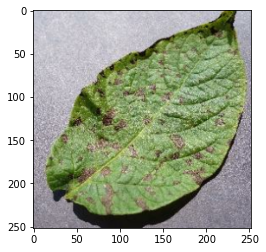

In [33]:
for images_batch, labels_batch in test_data_set.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
model.save("./model_1")

INFO:tensorflow:Assets written to: ./model_1\assets


INFO:tensorflow:Assets written to: ./model_1\assets
